# TimeSHAP

#### Import

In [1]:
import numpy as np
import pandas as pd
from typing import Callable, Union
from timeshap.explainer.kernel import TimeShapKernel

from Load_and_Preprocess_Aachen import preprocess_aachen_dataset
from LSTM_Model_Training import load_model_structure_and_weights, plot_predictions_vs_actual, plot_residuals

import plotly.graph_objects as go
from plotly.subplots import make_subplots


import altair as alt
import copy

#### Variables

In [ ]:
# Define the file path for the dataset
file_path = '/Users/sigurdgjerdingen/Student/Master kode/Master_Herstad-Gjerdingen/Aachen/Degradation_Prediction_Dataset_ISEA.mat'

# Define the number of test cells to be used
test_cell_count = 3

# Set the global random seed for reproducibility
random_state = 52
np.random.seed(random_state)


: 

: 

## Loading and Preprocessing Data

In [ ]:
# Load and preprocess Aachen data
preprocessed_full = preprocess_aachen_dataset(
    file_path,
    test_cell_count=3,
    random_state=random_state,
    phase=None,
    log_transform=False
)

# Assign feature splits to LSTM-specific variables
X_train_lstm = preprocessed_full["X_train"]
X_val_lstm   = preprocessed_full["X_val"]
X_test_lstm  = preprocessed_full["X_test"]

# Also extract the target variables
y_train_norm = preprocessed_full["y_train"]
y_val_norm   = preprocessed_full["y_val"]
y_test_norm  = preprocessed_full["y_test"]

# Assign the y_max value
y_max = preprocessed_full["y_max"]

# Print the shapes to verify the assignments
print("  X_train_lstm:", X_train_lstm.shape)
print("  X_val_lstm:  ", X_val_lstm.shape)
print("  X_test_lstm: ", X_test_lstm.shape)
print("  y_train:", y_train_norm.shape)
print("  y_val:  ", y_val_norm.shape)
print("  y_test: ", y_test_norm.shape)

  X_train_lstm: (7190, 272, 1)
  X_val_lstm:   (1798, 272, 1)
  X_test_lstm:  (595, 272, 1)
  y_train: (7190,)
  y_val:   (1798,)
  y_test:  (595,)


: 

## Load model

In [ ]:
# Load the model structure and weights from the specified file
model = load_model_structure_and_weights('model_20250131_123220')

# Display the model summary to verify the structure and loaded weights
model

Checking for model files in the following paths:
Structure file: Aachen/Models/model_20250131_123220.structure.json
Weights file: Aachen/Models/model_20250131_123220.weights.h5
Contents of directory 'Aachen/Models':
['model_20250127_135003.structure.json', 'model_20250131_124416.weights.h5', 'model_20250127_135003.weights.h5', 'model_20250128_130021.structure.json', 'model_20250128_130021.weights.h5', 'model_20250131_123220.structure.json', 'model_20250131_124416.structure.json', 'model_20250131_123220.weights.h5']
Model loaded from Aachen/Models/model_20250131_123220.structure.json and Aachen/Models/model_20250131_123220.weights.h5


<Sequential name=sequential_1, built=True>

: 

## Test model

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5791e-04 - mae: 0.0192

Test Loss: 0.0011460963869467378
Test MAE: 0.027306677773594856
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
   Actual RUL80  Predicted RUL80
0        1060.0      1031.006592
1        1055.0      1031.462646
2        1050.0      1029.203613
3        1045.0      1024.487549
4        1040.0      1017.905579


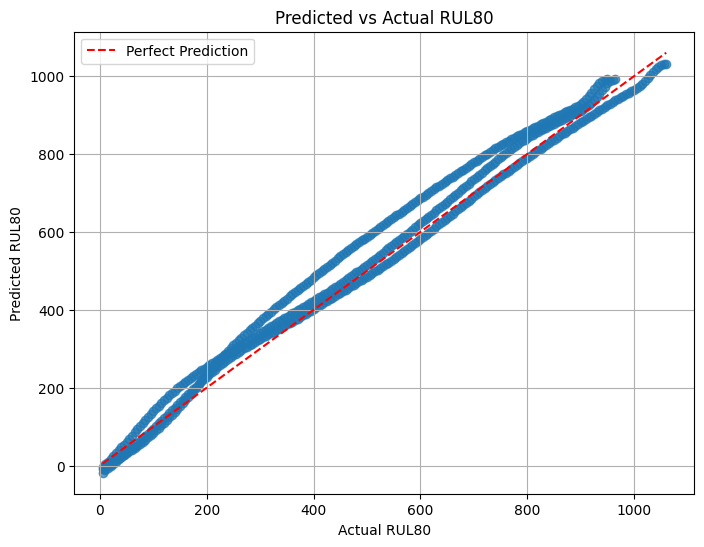

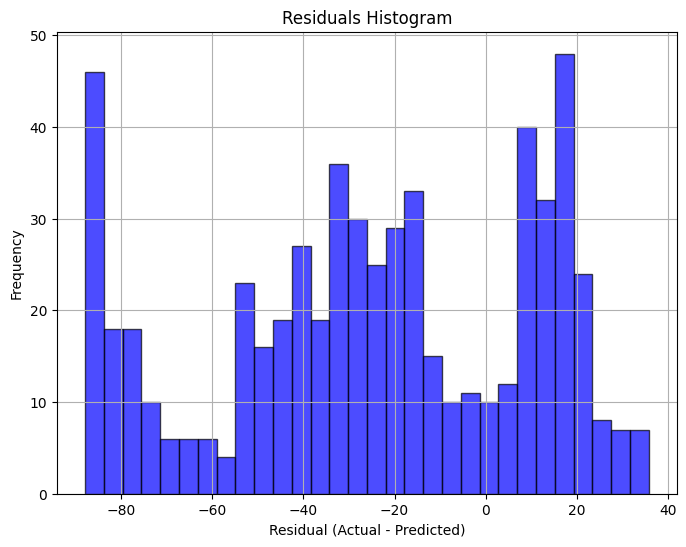

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 272, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 48)             │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │         1,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,805 (135.96 KB)

 Trainable params: 11,601 (45.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,204 (90.64 KB)

None


: 

In [ ]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_lstm, y_test_norm, verbose=1)
print(f"\nTest Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Make predictions on the test set
y_pred = model.predict(X_test_lstm)

# Rescale predictions and test data back to the original range
y_pred_rescaled = y_pred.flatten() * y_max
y_test_rescaled = y_test_norm * y_max

# Compare actual and predicted values
results = pd.DataFrame({
    "Actual RUL80": y_test_rescaled,
    "Predicted RUL80": y_pred_rescaled
})
print(results.head())

# Plot predictions vs actual
plot_predictions_vs_actual(y_test_rescaled, y_pred_rescaled)

# Plot residuals
plot_residuals(y_test_rescaled, y_pred_rescaled)

# Print model summary
print(model.summary())

### Model tests on trimmed data

In [ ]:
def evaluate_model_on_trimmed_sequences(model, X_test):
    """
    Evaluates the model on each trimmed sequence from X_test.
    
    Parameters
    ----------
    model : callable
        The model to be evaluated. It should accept a 3-D numpy array of shape (1, seq_len, 1)
        and return a 2-D numpy array (for example, predictions).
    X_test : np.ndarray
        Test sequences with shape (n_samples, seq_len, 1). These sequences are assumed to be padded
        (e.g., with zeros) to a fixed length.
    
    Returns
    -------
    list
        A list of model predictions, one for each trimmed sequence.
    """
    predictions = []
    for i, seq in enumerate(X_test):
        # Compute a mask for the current sequence: True for timesteps where not all features are zero.
        mask = ~np.all(seq == 0, axis=-1)
        # Trim the sequence using the mask.
        trimmed_seq = seq[mask, :]
        # Add the batch dimension so that the sequence has shape (1, trimmed_seq_len, 1)
        trimmed_seq = trimmed_seq[np.newaxis, :, :]
        
        # Evaluate the model on the trimmed sequence.
        pred = model(trimmed_seq)
        predictions.append(pred)
        
        # Optionally print the shape for debugging.
        print(f"Sequence {i}: original length = {seq.shape[0]}, trimmed length = {trimmed_seq.shape[1]}")
    
    # Convert the list of predictions to a numpy array.
    predictions = np.array(predictions).squeeze()  # Remove the batch dimension.
    return predictions

: 

Sequence 0: original length = 272, trimmed length = 21
Sequence 1: original length = 272, trimmed length = 22
Sequence 2: original length = 272, trimmed length = 23
Sequence 3: original length = 272, trimmed length = 24
Sequence 4: original length = 272, trimmed length = 25
Sequence 5: original length = 272, trimmed length = 26
Sequence 6: original length = 272, trimmed length = 27
Sequence 7: original length = 272, trimmed length = 28
Sequence 8: original length = 272, trimmed length = 29
Sequence 9: original length = 272, trimmed length = 30
Sequence 10: original length = 272, trimmed length = 31
Sequence 11: original length = 272, trimmed length = 32
Sequence 12: original length = 272, trimmed length = 33
Sequence 13: original length = 272, trimmed length = 34
Sequence 14: original length = 272, trimmed length = 35
Sequence 15: original length = 272, trimmed length = 36
Sequence 16: original length = 272, trimmed length = 37
Sequence 17: original length = 272, trimmed length = 38
Se

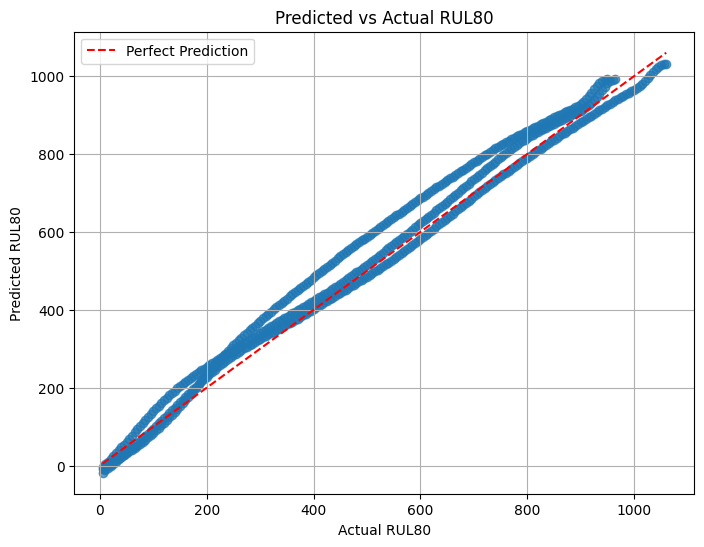

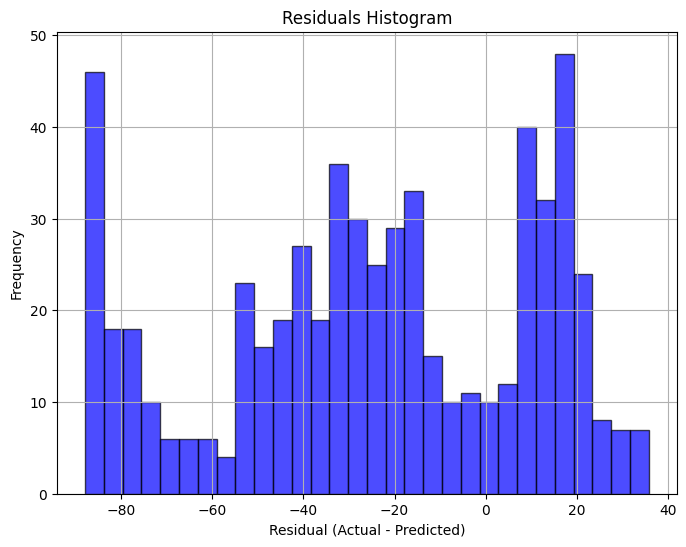

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 272, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 48)             │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │         1,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,805 (135.96 KB)

 Trainable params: 11,601 (45.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,204 (90.64 KB)

None


: 

In [ ]:
# Make predictions on the test set
y_pred_trimmed = evaluate_model_on_trimmed_sequences(model, X_test_lstm)


# Rescale predictions and test data back to the original range
y_pred_trimmed_rescaled = y_pred_trimmed.flatten() * y_max
y_test_rescaled = y_test_norm * y_max

# Compare actual and predicted values
results = pd.DataFrame({
    "Actual RUL80": y_test_rescaled,
    "Predicted RUL80": y_pred_trimmed_rescaled
})
print(results.head())

# Plot predictions vs actual
plot_predictions_vs_actual(y_test_rescaled, y_pred_trimmed_rescaled)

# Plot residuals
plot_residuals(y_test_rescaled, y_pred_trimmed_rescaled)

# Print model summary
print(model.summary())

In [ ]:
# Plot the original and trimmed predictions in the same plot
fig = go.Figure()

# Add the original predictions
fig.add_trace(go.Scatter(
    x=np.arange(len(y_pred_rescaled)),
    y=y_pred_rescaled,
    mode="lines",
    name="Original Predictions"
))

# Add the trimmed predictions
fig.add_trace(go.Scatter(
    x=np.arange(len(y_pred_trimmed_rescaled)),
    y=y_pred_trimmed_rescaled,
    mode="lines",
    name="Trimmed Predictions"
))

# Update the layout
fig.update_layout(
    title="Original and Trimmed Predictions",
    xaxis_title="Sample Index",
    yaxis_title="Predicted RUL80"
)


: 

The predictions from model are approximate the same both when the data is trimmed and untrimmed

## TimeSHAP

### Model entry point

In [ ]:
# Define the model prediction function
f = lambda x: model.predict(x)

: 

### Baseline event

In [ ]:
def avg_rul(X_train_lstm):
    # Reshape the array to 2D for easier processing
    X_train_lstm_2d = X_train_lstm.reshape(-1, X_train_lstm.shape[-1])
    
    # Create a mask to exclude rows that are all zeros
    non_zero_mask = np.any(X_train_lstm_2d != 0, axis=1)
    
    # Calculate the mean of the non-zero rows
    avg = np.mean(X_train_lstm_2d[non_zero_mask])
    
    # Return the average as a NumPy array with shape (1, 1)
    return np.array([[avg]])

average_event = avg_rul(X_train_lstm)

average_event

array([[0.6724684]], dtype=float32)

: 

### Local explanations

#### Helper functions

In [ ]:
def get_random_sequence(X_test):
    """
    Select a random sequence from the test set without trimming any timesteps.
    
    Parameters
    ----------
    X_test : np.ndarray
        Test set with shape [n_samples, seq_len, n_features].
    
    Returns
    -------
    np.ndarray
        A random sequence with shape [1, seq_len, n_features].
    """
    random_index = np.random.randint(0, len(X_test))
    # Select a random sequence and add a batch dimension (resulting shape: [1, seq_len, n_features])
    random_sequence = X_test[random_index][np.newaxis, :, :]
    
    print("Random index:", random_index)
    print("Random sequence shape:", random_sequence.shape)
    return random_sequence

: 

In [ ]:
def get_random_trimmed_sequence(X_test):
    """
    Select a random sequence from the test set and trim out all timesteps
    that are entirely zeros.
    
    Parameters
    ----------
    X_test : np.ndarray
        Test set with shape [n_samples, seq_len, n_features].
    
    Returns
    -------
    np.ndarray
        A trimmed sequence with shape [1, x, n_features], where x is the number
        of non-zero timesteps.
    """
    random_index = np.random.randint(0, len(X_test))
    # Select a random sequence and add a batch dimension (shape: [1, seq_len, n_features])
    random_sequence = X_test[random_index][np.newaxis, :, :]
    
    # Create a mask for timesteps that are not all zeros (for the first and only sample)
    mask = ~np.all(random_sequence[0] == 0, axis=-1)
    
    # Apply the mask along the time axis
    trimmed_sequence = random_sequence[:, mask, :]
    
    print("Random index:", random_index)
    print("Trimmed sequence shape:", trimmed_sequence.shape)
    return trimmed_sequence

: 

In [ ]:
def create_dual_axis_explanation_plot(trimmed_sequence, f, event_dict, baseline, pruned_idx=0):
    """
    Generates a dual-axis plot for a random trimmed sequence from the test set.
    One y-axis shows the Shapley values from the event-level explanation, and
    the other shows the corresponding sequence values.
    
    Parameters
    ----------
    X_test : np.ndarray
        Test set with shape [n_samples, seq_len, n_features].
    f : Callable[[np.ndarray], np.ndarray]
        The model function to be explained.
    event_dict : dict
        Dictionary of event configuration parameters.
    baseline : Union[pd.DataFrame, np.ndarray]
        The baseline event for the explanation.
    pruned_idx : int, optional
        The index at which the sequence is pruned (default is 0).
    
    Returns
    -------
    plotly.graph_objects.Figure
        A dual-axis plot figure showing Shapley values and sequence values.
    """
   # Compute the event-level explanation using your function
    event_explanation = local_event_level_single_feature_standalone(
        f=f,
        data=trimmed_sequence,
        event_dict=event_dict,
        baseline=baseline,
        pruned_idx=pruned_idx
    )
    
    # Extract numeric event number from the "Event" column (e.g., "Event 3" -> 3)
    event_explanation['Event Number'] = event_explanation['Event'].str.extract(r'Event (\d+)').astype(int)
    
    # Get the sequence values (flattened from shape [1, x, 1] to [x])
    sequence_line = trimmed_sequence.flatten()
    
    # Create a dual y-axis plot using Plotly
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Add Shapley Value trace on the primary y-axis.
    fig.add_trace(
        go.Scatter(
            x=event_explanation["Event Number"],
            y=event_explanation["Shapley Value"],
            mode='lines',
            name='Shapley Value'
        ),
        secondary_y=False
    )
    
    # Add Sequence Values trace on the secondary y-axis.
    fig.add_trace(
        go.Scatter(
            x=event_explanation["Event Number"],
            y=sequence_line,
            mode='lines',
            name='Sequence Values'
        ),
        secondary_y=True
    )
    
    # Update layout and y-axes titles.
    fig.update_layout(
        title="Event-level Explanation with Dual Y-Axis",
        xaxis_title="Event Number"
    )
    fig.update_yaxes(title_text="Shapley Value", secondary_y=False)
    fig.update_yaxes(title_text="Sequence Value", secondary_y=True)
    
    return fig

: 

In [ ]:
def local_event_level_single_feature_standalone(
    f: Callable[[np.ndarray], np.ndarray],
    data: Union[pd.DataFrame, np.ndarray],
    event_dict: dict,
    baseline: Union[pd.DataFrame, np.ndarray],
    pruned_idx: int
) -> pd.DataFrame:
    """
    Computes event-level (cell-level) explanations for a single-feature model using
    the easier-to-use event mode of TimeShapKernel.
    
    Each time step (after the pruned index) is treated as an event.
    
    Parameters
    ----------
    f : Callable[[np.ndarray], np.ndarray]
        Model function that accepts a 3-D numpy array of shape (1, seq_len, 1)
        and returns a 2-D numpy array.
    data : Union[pd.DataFrame, np.ndarray]
        Input instance to be explained. If a DataFrame, it will be converted to a
        3-D numpy array.
    event_dict : dict
        Dictionary with parameters for the event explanation. Expected keys include:
          - 'rs': random seed (default: 42)
          - 'nsamples': number of samples for the kernel estimation (default: 1000)
    baseline : Union[pd.DataFrame, np.ndarray]
        Baseline data (e.g. an average event) used for integrating out features.
    pruned_idx : int
        The index at which the sequence is pruned (e.g. 0 if no pruning is applied).
        
    Returns
    -------
    pd.DataFrame
        A DataFrame with columns ['Event', 'Shapley Value'] listing the explanation
        for each event (time step).
    """
    # Convert DataFrame to numpy array if needed.
    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()
        # If 2-D, expand to 3-D (1, seq_len, num_features)
        if len(data.shape) == 2:
            data = np.expand_dims(data, axis=0)
        # Ensure that the last dimension is 1 (since we have one feature)
        if data.shape[-1] != 1:
            data = data[..., np.newaxis]
    
    # Extract parameters for the explainer from event_dict.
    random_seed = event_dict.get('rs', 42)
    nsamples = event_dict.get('nsamples', 1000)
    
    # Instantiate the TimeShapKernel in event mode.
    # In event mode, the kernel automatically uses all time steps (after pruned_idx)
    # as the events to be explained.
    explainer = TimeShapKernel(f, baseline, random_seed, mode="event")
    
    # Compute Shapley values for the instance.
    # The output is an array of one value per event.
    shap_values_arr = explainer.shap_values(data, pruning_idx=pruned_idx, nsamples=nsamples)
    
    # In event mode, internally the explainer computes:
    #     self.varyingInds = np.arange(data.shape[1]-1, pruned_idx-1, -1)
    # so that the first computed value corresponds to the last time step.
    # To list events in natural order (from first event to last), we reverse the array.
    shap_values_arr_reversed = shap_values_arr[::-1]
    
    # Create labels for events.
    # Events correspond to the time steps starting at pruned_idx up to the end of the sequence.
    events = [f"Event {i}" for i in range(pruned_idx, data.shape[1])]
    
    # Build the explanation DataFrame.
    explanation_df = pd.DataFrame({
        "Event": events,
        "Shapley Value": shap_values_arr_reversed
    })
    
    return explanation_df

: 

### Local Event-Level Explanation

In [1]:
# Minimal event configuration.
event_dict = {
    'rs': random_state,          # Random seed.
    'nsamples': 10000    # Number of samples for the kernel estimation.
}

pruned_idx = 0  # No pruning in this simple example.

# Get a random trimmed sequence from the test set.
trimmed_sequence = get_random_trimmed_sequence(X_test_lstm)

fig = create_dual_axis_explanation_plot(trimmed_sequence, f, event_dict, average_event, pruned_idx)
fig.show()

NameError: name 'random_state' is not defined

In [80]:
# Get a random untrimmed sequence from the test set
untrimmed_sequence = get_random_sequence(X_test_lstm)

# Create a dual-axis explanation plot for the untrimmed sequence
fig = create_dual_axis_explanation_plot(untrimmed_sequence, f, event_dict, average_event, pruned_idx)

# Display the plot
fig.show()

Random index: 566
Random sequence shape: (1, 272, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


### Why different Shap-results

- Non-Trimmed Sequences: The explanation includes padded zeros, which leads to low but volatile Shapley values across the entire sequence—even in regions that the model largely ignores.

- Trimmed Sequences: Only the meaningful, nonzero parts are considered. The Shapley values become more consistent and focused on the parts of the sequence that truly affect the model's prediction.

This behavior suggests that your model is effectively ignoring the padded sections during prediction, and the explanation method is reflecting that by producing more stable, interpretable results when the padding is removed.

### Global explanations

#### Helper functions

In [81]:
def event_explain_all(f: callable,
                      data: np.ndarray,
                      event_dict: dict,
                      baseline: np.ndarray = None,
                      append_to_files: bool = False,
                      verbose: bool = False) -> pd.DataFrame:
    """
    Calculates event-level explanations for all sequences in the provided numpy array,
    after trimming out any zero-padded timesteps.
    
    Assumes that:
      - `data` is a NumPy array of shape (n_samples, seq_len, 1)
      - The model uses only one feature.
      - A fixed pruning index of 0 is used (i.e. no pruning).
    
    Parameters
    ----------
    f : callable
        The model function that accepts a 3-D numpy array (n_samples, seq_len, 1)
        and returns a 2-D numpy array (e.g., predictions).
    data : np.ndarray
        Test sequences with shape (n_samples, seq_len, 1).
    event_dict : dict
        Dictionary with parameters for the event-level explanation.
        Expected keys include:
          - 'rs': random seed (int)
          - 'nsamples': number of samples for kernel estimation (int)
    baseline : np.ndarray, optional
        Baseline data (e.g., an average event or sequence) with shape (seq_len, 1)
        or (1, seq_len, 1).
    append_to_files : bool, optional
        (Not used in this simplified version.)
    verbose : bool, optional
        If True, prints additional debugging information.
        
    Returns
    -------
    pd.DataFrame
        A DataFrame with aggregated event-level explanations.
        The columns are:
          - 'Event Number': Numeric index of the event (time step)
          - 'Average Shapley Value': Averaged Shapley value for that event index across sequences.
    """
    ret_event_data = []
    # Get the parameters from the event dict
    rs = event_dict.get('rs', 42)
    ns = event_dict.get('nsamples', 10000)
    # For simplicity, we fix the pruning index to 0 (i.e. no pruning)
    pruning_idx = 0

    # Loop over every sequence in the numpy array
    for i, sequence in enumerate(data):
        # Convert sequence to float64 for consistency
        sequence = sequence.astype(np.float64)
        
        # Compute a mask for the current sequence: True for timesteps where not all features are zero.
        mask = ~np.all(sequence == 0, axis=-1)
        # Trim the sequence using its own mask (resulting shape: (trimmed_seq_len, 1))
        trimmed_seq = sequence[mask, :]
        # Add the batch dimension so that the shape becomes (1, trimmed_seq_len, 1)
        trimmed_seq = trimmed_seq[np.newaxis, :, :]

        # Prepare the local event dictionary
        local_event_dict = {'rs': rs, 'nsamples': ns}
        
        # Compute the event-level explanation for the current trimmed sequence.
        # This function is assumed to return a DataFrame with columns ['Event', 'Shapley Value'].
        event_data = local_event_level_single_feature_standalone(f, trimmed_seq, local_event_dict, baseline, pruning_idx)
        
        # Extract numeric event index from the 'Event' column (e.g., "Event 0" becomes 0)
        event_data['Event Number'] = event_data['Event'].str.extract(r'Event (\d+)').astype(int)
        
        if verbose:
            print(f"Sequence {i}: original length = {sequence.shape[0]}, trimmed length = {trimmed_seq.shape[1]}, "
                  f"event indices: {event_data['Event Number'].tolist()}")
        
        ret_event_data.append(event_data)
    
    # Concatenate all individual explanation DataFrames.
    combined_df = pd.concat(ret_event_data, ignore_index=True)
    
    # Group by 'Event Number' and average the Shapley values.
    aggregated_df = combined_df.groupby('Event Number')['Shapley Value'].mean().reset_index()
    aggregated_df.rename(columns={'Shapley Value': 'Average Shapley Value'}, inplace=True)
    
    return aggregated_df

In [83]:
def plot_global_event(aggregated_df: pd.DataFrame,
                      plot_parameters: dict = None) -> go.Figure:
    """
    Plots global event explanations using Plotly.

    Parameters
    ----------
    aggregated_df : pd.DataFrame
        DataFrame with columns ['Event Number', 'Average Shapley Value'].
    plot_parameters : dict, optional
        Dictionary with optional plot parameters:
            - 'height': height of the plot (default 600)
            - 'width': width of the plot (default 1000)
            - 'axis_lims': y-axis domain for Average Shapley Value (default None)
            - 'event_limit': minimum event number to include (default: None, include all)

    Returns
    -------
    go.Figure
        A Plotly Figure representing the global event explanations.
    """
    # Make a copy so we don't modify the original DataFrame
    data = copy.deepcopy(aggregated_df)

    # Set default plot parameters if not provided
    if plot_parameters is None:
        plot_parameters = {}
    height = plot_parameters.get('height', 600)
    width = plot_parameters.get('width', 1000)
    axis_lims = plot_parameters.get('axis_lims', None)
    event_limit = plot_parameters.get('event_limit', None)

    # Optionally filter out events below a certain event number
    if event_limit is not None:
        data = data[data['Event Number'] >= event_limit]

    # For plotting, add 1 to the event number so that, e.g., event 0 becomes 1
    data['Plot Event Number'] = data['Event Number'] + 1

    # Create the Plotly figure
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=data['Plot Event Number'],
        y=data['Average Shapley Value'],
        mode='lines+markers',
        marker=dict(size=8, color="#48caaa"),
        line=dict(width=2),
        name='Average Shapley Value'
    ))

    fig.update_layout(
        title="Global Event Explanation",
        xaxis_title="Event Number",
        yaxis_title="Average Shapley Value",
        width=width,
        height=height,
        yaxis=dict(range=axis_lims)
    )

    return fig

In [82]:
event_dict = {'rs': random_state, 'nsamples': 1000}

event_data = event_explain_all(f, X_test_lstm, event_dict, average_event, verbose=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Sequence 0: original length = 272, trimmed length = 21, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Sequence 1: original length = 272, trimmed length = 22, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Sequence 2: original length = 272, trimmed length = 23, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Sequence 3: original length = 272, trimmed length = 24, event indices: [0, 1, 2, 3, 4, 5,

In [86]:
event_data

Event Number  Average Shapley Value
0               0          -5.016609e-07
1               1           8.634442e-06
2               2          -1.005665e-06
3               3          -4.196202e-06
4               4          -3.475742e-05
..            ...                    ...
227           227          -1.385908e-01
228           228          -1.522625e-01
229           229          -1.622343e-01
230           230          -1.671745e-01
231           231          -1.621424e-01

[232 rows x 2 columns]

In [87]:
global_event_chart = plot_global_event(event_data)

global_event_chart

### Normalize by relative Position

When you average over all sequences for each absolute event index, you run into two issues:

- Early Events: For long sequences, many of the early events are padded (or absent) and show near‐zero Shapley values, which “pulls” the mean down—even if some short sequences have higher values there.
- Late Events: For long sequences, the later events (which have high Shapley values) occur only in those sequences. If many sequences are shorter and do not have those events at all, then the average at those indices is computed over a smaller sample, and the overall mean can be “dragged” down by the large number of zeros (or missing values) from the shorter sequences.

Therfore Shapley values can be aggregated across relative data into bins.

In [99]:
def plot_normalized_explanation(aggregated_df: pd.DataFrame, plot_parameters: dict = None) -> go.Figure:
    """
    Plots the normalized event-level explanations using Plotly.
    
    The DataFrame is expected to have the following columns:
      - 'Bin Center': The center of the relative bin (normalized position between 0 and 1).
      - 'Mean Shapley Value': The mean Shapley value for events in that bin.
      - 'Median Shapley Value': The median Shapley value for events in that bin.
      - 'Count': The number of events in that bin (optional for tooltip).
    
    Parameters
    ----------
    aggregated_df : pd.DataFrame
        Aggregated DataFrame with normalized event explanations.
    plot_parameters : dict, optional
        Optional parameters for the plot:
            - 'width': Width of the plot (default 500).
            - 'height': Height of the plot (default 300).
            - 'title': Title of the plot (default 'Normalized Event Explanation').
    
    Returns
    -------
    go.Figure
        A Plotly Figure object representing the normalized event-level explanations.
    """
    if plot_parameters is None:
        plot_parameters = {}
    width = plot_parameters.get('width', 500)
    height = plot_parameters.get('height', 300)
    title = plot_parameters.get('title', 'Normalized Event Explanation')
    
    # Create the Plotly figure
    fig = go.Figure()
    
    # Add a trace for the mean Shapley values
    fig.add_trace(go.Scatter(
        x=aggregated_df['Bin Center'],
        y=aggregated_df['Mean Shapley Value'],
        mode='lines+markers',
        name='Mean Shapley Value',
        marker=dict(color='blue'),
        line=dict(color='blue')
    ))
    
    # Add a trace for the median Shapley values
    fig.add_trace(go.Scatter(
        x=aggregated_df['Bin Center'],
        y=aggregated_df['Median Shapley Value'],
        mode='lines+markers',
        name='Median Shapley Value',
        marker=dict(color='red'),
        line=dict(color='red')
    ))
    
    fig.update_layout(
        title=title,
        xaxis_title='Relative Position (Bin Center)',
        yaxis_title='Shapley Value',
        width=width,
        height=height
    )
    
    return fig

In [ ]:
def event_explain_all_normalized(f: callable,
                                 data: np.ndarray,
                                 event_dict: dict,
                                 baseline: np.ndarray = None,
                                 num_bins: int = 20,
                                 verbose: bool = False) -> pd.DataFrame:
    """
    Calculates event-level explanations for all sequences in the provided numpy array,
    after trimming out any zero-padded timesteps, and aggregates the explanations based
    on the relative position of the event within the trimmed sequence.
    
    The relative position is computed as:
        Relative Position = (Event Index) / (L - 1)
    where L is the length of the trimmed sequence.
    
    Parameters
    ----------
    f : callable
        The model function that accepts a 3-D numpy array of shape (n_samples, seq_len, 1)
        and returns a 2-D numpy array (e.g., predictions).
    data : np.ndarray
        Test sequences with shape (n_samples, seq_len, 1).
    event_dict : dict
        Dictionary with parameters for the event-level explanation.
        Expected keys include:
            - 'rs': random seed (int)
            - 'nsamples': number of samples for kernel estimation (int)
    baseline : np.ndarray, optional
        Baseline data (e.g., an average event or sequence) with shape (seq_len, 1) or (1, seq_len, 1).
    num_bins : int, optional
        Number of bins to use when aggregating relative positions (default is 20).
    verbose : bool, optional
        If True, prints additional debugging information.
        
    Returns
    -------
    pd.DataFrame
        A DataFrame with aggregated event-level explanations on a relative scale.
        The columns include:
            - 'Relative Bin': The bin index for the normalized event position.
            - 'Mean Shapley Value': Mean Shapley value for events in that bin.
            - 'Median Shapley Value': Median Shapley value for events in that bin.
            - 'Count': Number of events in that bin.
            - 'Bin Center': The center of the relative bin (for plotting).
    """
    ret_event_data = []
    rs = event_dict.get('rs', 42)
    ns = event_dict.get('nsamples', 1000)
    pruning_idx = 0  # Fixed, no pruning

    # Process each sequence in the dataset
    for i, sequence in enumerate(data):
        sequence = sequence.astype(np.float64)
        # Create a mask for timesteps that are not entirely zeros
        mask = ~np.all(sequence == 0, axis=-1)
        # Trim the sequence using its own mask
        trimmed_seq = sequence[mask, :]
        # Add the batch dimension (now shape: (1, trimmed_seq_len, 1))
        trimmed_seq = trimmed_seq[np.newaxis, :, :]

        # Compute event-level explanation for the trimmed sequence
        local_event_dict = {'rs': rs, 'nsamples': ns}
        event_data = local_event_level_single_feature_standalone(f, trimmed_seq, local_event_dict, baseline, pruning_idx)
        
        # Extract numeric event index from the 'Event' column (e.g., "Event 0" -> 0)
        event_data['Event Number'] = event_data['Event'].str.extract(r'Event (\d+)').astype(int)
        
        # Compute relative position: scale event index to [0, 1]
        L = trimmed_seq.shape[1]
        if L > 1:
            event_data['Relative Position'] = event_data['Event Number'] / (L - 1)
        else:
            event_data['Relative Position'] = 0.0
        
        if verbose:
            print(f"Sequence {i}: original length = {sequence.shape[0]}, trimmed length = {L}, "
                  f"event indices: {event_data['Event Number'].tolist()}, "
                  f"relative positions: {event_data['Relative Position'].tolist()}")
        
        ret_event_data.append(event_data)
    
    # Combine explanations from all sequences
    combined_df = pd.concat(ret_event_data, ignore_index=True)
    
    # Bin the relative positions into 'num_bins' equal bins in the range [0, 1]
    bins = np.linspace(0, 1, num_bins + 1)
    combined_df['Relative Bin'] = pd.cut(combined_df['Relative Position'], bins=bins, include_lowest=True, labels=False)
    
    # Aggregate the Shapley values by these relative bins
    aggregated_df = combined_df.groupby('Relative Bin')['Shapley Value'].agg(['mean', 'median', 'count']).reset_index()
    aggregated_df.rename(columns={'mean': 'Mean Shapley Value', 'median': 'Median Shapley Value', 'count': 'Count'}, inplace=True)
    
    # Compute the center of each bin for plotting purposes
    bin_centers = (bins[:-1] + bins[1:]) / 2
    aggregated_df['Bin Center'] = aggregated_df['Relative Bin'].apply(lambda x: bin_centers[int(x)])
    
    return aggregated_df

In [96]:
event_dict = {'rs': random_state, 'nsamples': 1000}

normalized_df = event_explain_all_normalized(f, X_test_lstm, event_dict, average_event, num_bins=30, verbose=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Sequence 0: original length = 272, trimmed length = 21, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], relative positions: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Sequence 1: original length = 272, trimmed length = 22, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], relative positions: [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0

In [100]:
fig = plot_normalized_explanation(normalized_df, {'width':1000, 'height':600, 'title':'Normalized Explanation'})
fig.show()

### Coarse view with only 10 bins (insted of 30)  

In [94]:
event_dict = {'rs': random_state, 'nsamples': 1000}

normalized_df_coarse = event_explain_all_normalized(f, X_test_lstm, event_dict, average_event, num_bins=10, verbose=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Sequence 0: original length = 272, trimmed length = 21, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], relative positions: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Sequence 1: original length = 272, trimmed length = 22, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], relative positions: [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 

In [95]:
fig = plot_normalized_explanation(normalized_df_coarse, {'width':1000, 'height':600, 'title':'Normalized Explanation'})
fig.show()

### Thougts on the results

The model appears to be most focused on the last values of the sequence


In [13]:
from timeshap.explainer import global_report

model_feature = ["rul"]
schema = ["rul"]
plot_featrues = {"rul": "RUL"}

pruning_dict = {'tol': [0.05, 0.075], 'path': 'outputs/prun_all_tf.csv'}
event_dict = {'path': 'outputs/event_all_tf.csv', 'rs': 42, 'nsamples': 32000}
feature_dict = {'path': 'outputs/feature_all_tf.csv', 'rs': 42, 'nsamples': 32000, 'feature_names': None, 'plot_features': None,}

prun_stats, global_plot = global_report(
    f,                     # your model callable
    random_sequences,      # your NumPy array data
    pruning_dict,
    event_dict,
    feature_dict,
    average_event,              # baseline computed above
    model_features=None,        # provided as a list ["price"]
    schema=None,                # provided schema, also ["price"]
    entity_col=None,       # not applicable for NumPy array input
    time_col=None,         # not applicable here
    append_to_files=False,
    max_instances=1000,
    verbose=True
)

prun_stats

Assuming all features are model features
Calculating pruning algorithm
No time col provided, assuming dataset is ordered ascendingly by date
Allowed importance for pruned events: None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
len 0 | importance -0.1946868598461151
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
len -1 | importance -0.17362748086452484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
len -2 | importance -0.14873306453227997
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
len -3 | importance -0.12387983500957489
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
len -4 | importance -0.10195152461528778
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━

ValueError: Shape of passed values is (2730, 3), indices imply (2730, 4)

In [14]:
global_plot

NameError: name 'global_plot' is not defined

### Individual Plots

#### Local Plots

In [15]:
from timeshap.explainer import local_pruning
from timeshap.plot import plot_temp_coalition_pruning

pruning_dict = {'tol': 0,}
coal_plot_data, coal_prun_idx = local_pruning(f, random_sequence, pruning_dict, average_event)
# coal_prun_idx is in negative terms
pruning_idx = random_sequence.shape[1] + coal_prun_idx

pruning_plot = plot_temp_coalition_pruning(coal_plot_data, coal_prun_idx, plot_limit=280)
pruning_plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.LayerChart(...)

In [16]:
from timeshap.explainer import local_event
from timeshap.plot import plot_event_heatmap
pruning_idx = 0

event_dict = {'rs': 42, 'nsamples': 32000}
event_data = local_event(f, random_sequence, event_dict, entity_uuid=None, entity_col=None, baseline=average_event, pruned_idx=pruning_idx)
event_plot = plot_event_heatmap(event_data)
event_plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step


the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.LayerChart(...)

In [17]:
from timeshap.explainer import local_feat
from timeshap.plot import plot_feat_barplot

feature_dict = {'rs': 42, 'nsamples': 32000, 'feature_names': None, 'plot_features': None}
feature_data = local_feat(f, 
                          random_sequence, 
                          feature_dict,
                          entity_uuid=None, 
                          entity_col=None,
                          baseline=average_event, 
                          pruned_idx=pruning_idx)

feature_plot = plot_feat_barplot(feature_data, feature_dict.get('top_feats'), feature_dict.get('plot_features'))
feature_plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.LayerChart(...)

In [18]:
from timeshap.explainer import local_cell_level
from timeshap.plot import plot_cell_level

cell_dict = {'rs': 42, 'nsamples': 32000, 'top_x_events': 5, 'top_x_feats': 1}
cell_data = local_cell_level(f, random_sequence, cell_dict, event_data, feature_data, entity_uuid=None, entity_col=None, baseline=average_event, pruned_idx=pruning_idx)
feat_names = list(feature_data['Feature'].values)[:-1] # exclude pruned events
cell_plot = plot_cell_level(cell_data, feat_names, feature_dict.get('plot_features'))
cell_plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.LayerChart(...)

In [27]:
# Add sequence IDs (if 'Cell' exists, we can use that)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

# Create DataFrames from the NumPy arrays
def create_dataframe(X, y, original_df, dataset_type):
    data_list = []
    for i in range(len(X)):
        sequence = X[i].flatten()  # Flatten the sequence for DataFrame representation
        sequence_length = np.count_nonzero(sequence)  # Actual non-padded sequence length
        cell_id = original_df.iloc[i]["Cell"] if "Cell" in original_df.columns else f"{dataset_type}_{i}"
        
        data_list.append({
            'sequence_id': cell_id,
            'sequence_length': sequence_length,
            'sequence': sequence,
            'RUL_normalized': y[i]
        })
    
    return pd.DataFrame(data_list)

# Create DataFrames
df_train_final = create_dataframe(X_train_lstm, y_train_norm, df_train, 'train')
df_val_final = create_dataframe(X_val_lstm, y_val_norm, df_val, 'val')
df_test_final = create_dataframe(X_test_lstm, y_test_norm, df_test, 'test')


In [28]:
from typing import Callable, Union
import numpy as np
import pandas as pd
from timeshap.explainer.kernel import TimeShapKernel

def local_event_level_single_feature_standalone(
    f: Callable[[np.ndarray], np.ndarray],
    data: Union[pd.DataFrame, np.ndarray],
    event_dict: dict,
    baseline: Union[pd.DataFrame, np.ndarray],
    pruned_idx: int
) -> pd.DataFrame:
    """
    Computes event-level (cell-level) explanations for a single-feature model using
    the easier-to-use event mode of TimeShapKernel.
    
    Each time step (after the pruned index) is treated as an event.
    
    Parameters
    ----------
    f : Callable[[np.ndarray], np.ndarray]
        Model function that accepts a 3-D numpy array of shape (1, seq_len, 1)
        and returns a 2-D numpy array.
    data : Union[pd.DataFrame, np.ndarray]
        Input instance to be explained. If a DataFrame, it will be converted to a
        3-D numpy array.
    event_dict : dict
        Dictionary with parameters for the event explanation. Expected keys include:
          - 'rs': random seed (default: 42)
          - 'nsamples': number of samples for the kernel estimation (default: 100)
    baseline : Union[pd.DataFrame, np.ndarray]
        Baseline data (e.g. an average event) used for integrating out features.
    pruned_idx : int
        The index at which the sequence is pruned (e.g. 0 if no pruning is applied).
        
    Returns
    -------
    pd.DataFrame
        A DataFrame with columns ['Event', 'Shapley Value'] listing the explanation
        for each event (time step).
    """
    # Convert DataFrame to numpy array if needed.
    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()
        # If 2-D, expand to 3-D (1, seq_len, num_features)
        if len(data.shape) == 2:
            data = np.expand_dims(data, axis=0)
        # Ensure that the last dimension is 1 (since we have one feature)
        if data.shape[-1] != 1:
            data = data[..., np.newaxis]
    
    # Extract parameters for the explainer from event_dict.
    random_seed = event_dict.get('rs', 42)
    nsamples = event_dict.get('nsamples', 100)
    
    # Instantiate the TimeShapKernel in event mode.
    # In event mode, the kernel automatically uses all time steps (after pruned_idx)
    # as the events to be explained.
    explainer = TimeShapKernel(f, baseline, random_seed, mode="event")
    
    # Compute Shapley values for the instance.
    # The output is an array of one value per event.
    shap_values_arr = explainer.shap_values(data, pruning_idx=pruned_idx, nsamples=nsamples)
    
    # In event mode, internally the explainer computes:
    #     self.varyingInds = np.arange(data.shape[1]-1, pruned_idx-1, -1)
    # so that the first computed value corresponds to the last time step.
    # To list events in natural order (from first event to last), we reverse the array.
    shap_values_arr_reversed = shap_values_arr[::-1]
    
    # Create labels for events.
    # Events correspond to the time steps starting at pruned_idx up to the end of the sequence.
    events = [f"Event {i}" for i in range(pruned_idx, data.shape[1])]
    
    # Build the explanation DataFrame.
    explanation_df = pd.DataFrame({
        "Event": events,
        "Shapley Value": shap_values_arr_reversed
    })
    
    return explanation_df


# Example usage:
if __name__ == "__main__":
   # Minimal event configuration.
    event_dict = {
        'rs': 42,          # Random seed.
        'nsamples': 10000    # Number of samples for the kernel estimation.
    }
    
    pruned_idx = 0  # No pruning in this simple example.
    
    # Get the event-level explanation.
    event_explanation = local_event_level_single_feature_standalone(
        f=f,
        data=random_sequence,
        event_dict=event_dict,
        baseline=average_event,
        pruned_idx=pruned_idx
    )
    
    print("Standalone Event-level Explanation (Single Feature):")
    print(event_explanation)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Standalone Event-level Explanation (Single Feature):
         Event  Shapley Value
0      Event 0       0.000000
1      Event 1       0.000000
2      Event 2       0.000000
3      Event 3      -0.002441
4      Event 4       0.000000
..         ...            ...
267  Event 267      -0.003033
268  Event 268       0.000000
269  Event 269       0.000000
270  Event 270       0.000000
271  Event 271      -0.005808

[272 rows x 2 columns]


In [30]:
# Make predictions on the test set
y_pred = model.predict(random_sequence)

# Rescale predictions and test data back to the original range
y_pred_rescaled = y_pred.flatten() * y_max

y_pred_rescaled

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([371.68304], dtype=float32)